Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\benlc\PASP_HCItutorial-main\KLIP_Processing\CH4
wavelength collapsing reduced data of shape (b, N, wv, y, x):(4, 126, 1, 1024, 1024)


"\n- make psf using H band raw star images, apply to fmpsf and see what happens\n- can also inject guess signal by adding an image that estimates the planet's psf to the klip processed image to better estimate pa, sep\n- read other papers and stuff! hr8799 looks exciting, can catch up on the potential companion that got disproved"

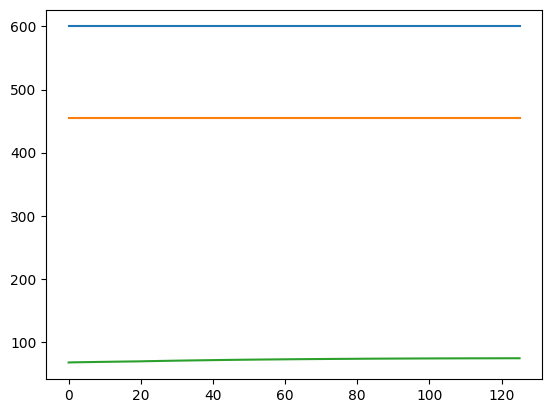

In [2]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
import os
import pyklip
import pyklip.klip as klip
from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm
import pyklip.parallelized as parallelized
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.instruments.Instrument import GenericData
import pyklip.instruments.NIRC2 as NIRC2
import astropy.units as u
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
import pyklip.fm as fm
import pyklip.fmlib.fmpsf as fmpsf
from astropy.convolution import convolve
%matplotlib inline

warnings.filterwarnings("ignore")

#returns median of aligned images to use as PSF
def ADI_psfs(psflist):  #add parangs to GenericData constructor
    rawpsfs = np.zeros((len(psflist), 1024, 1024))
    adjustedpsfs = np.zeros((len(psflist), 1024, 1024))
    alignedpsfs = np.zeros((len(psflist), 1024, 1024))
    #shiftentries = (701-60, 487-32)
    for i in range(len(psflist)):
        rawpsfs[i,0:120,0:64] = fits.getdata(psflist[i])
        adjustedpsfs[i, 701-60:701+60,487-32:487+32] = rawpsfs[i,0:120,0:64] // 3000 #normalize to background of zeroes, values used to be order of millions
        #adjustedpsfs[i,:,:] = fourier_shift(rawpsfs[i,:,:], shiftentries)
        if i != 0:
            shifts, error, diffphase = phase_cross_correlation(alignedpsfs[0,:,:], adjustedpsfs[i,:,:], upsample_factor=100)
            alignedpsfs[i,:,:] = fourier_shift(adjustedpsfs[i,:,:], shifts)
        else:
            alignedpsfs[0,:,:] = adjustedpsfs[0,:,:]
            

    fits.writeto('rawexample.fits',rawpsfs[1,:,:], overwrite=True)
    fits.writeto('alignedexample.fits',alignedpsfs[1,:,:], overwrite=True)
    medpsfs = np.nanmedian(alignedpsfs, axis=0)
    fits.writeto('psfs.fits', medpsfs, overwrite=True)

    
    return np.array([medpsfs[256:768, 256:768]])

    




def ADI_getImages(flist, xdim, ydim):
    rawcube = np.zeros((len(flist),xdim,ydim))
    ctrs= np.zeros((len(flist),2))
    parangs = np.zeros((len(flist)))
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        #find centers
        if i == 0:
            ctrs[i][0] = 611.4 - 256
            ctrs[i][1] = 436.2 - 256
        else:
            shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
                                                    upsample_factor=100,
                                                    normalization=None)
            ctrs[i][0] = ctrs[0][0] - shifts[0] - 256
            ctrs[i][1] = ctrs[0][1] - shifts[1] - 256

        parangs[i] = head['PARANG']

    plt.plot(parangs)
    plt.plot(ctrs)
    return rawcube[:,256:768,256:768], ctrs, parangs
        
    
#classical ADI
def cADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            #ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))
            
            aligned_cube[0,:,:] = rawcube[0,:,:]
            print(head)
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrPoisson[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va)
    
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    #plt.plot(ctrs)
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    return SNR_map, med_derot, ctrs[0]

#ADI
def ADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    ctrs= np.zeros((len(flist),2))
    parangs=np.zeros((len(flist)))
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        #find centers
        if i == 0:
            ctrs[i][0] = 600
            ctrs[i][1] = 455
        else:
            shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
                                                    upsample_factor=100,
                                                    normalization=None)
            ctrs[i][0] = ctrs[0][0] - shifts[0]
            ctrs[i][1] = ctrs[0][1] - shifts[1]##this allows the centers to be different, just to see what pyklip will do -- alternative is to make an N length array with every element equalling the first ctrs[0]
        
        ctrs[i][0] = 600
        ctrs[i][1] = 455
        #find parangs
        parangs[i] = head['PARANG']
        
            
    dataset = GenericData(rawcube, ctrs, IWA=6, parangs=parangs)
    sub_imgs = parallelized.klip_dataset(dataset, outputdir='KLIP_Processing/CH4',
                                        annuli=9,subsections=4,numbasis=[1,20,50,100],maxnumbasis=150,mode="ADI",
                                        movement=1)
    
    plt.plot(ctrs)
    plt.plot(parangs)
    #sub_imgs = parallelized.klip_dataset(imgs,mode='ADI')
    return sub_imgs, ctrs[0]
   
#Forward-Modeling
def forwardmodel(flist, psflist):
    instrument_psfs = ADI_psfs(psflist) #DiskFM, use data sent to u
    print(instrument_psfs.shape)
    datacube, ctrs = ADI_getImages(flist, 1024, 1024)
    fits.writeto('datacube', datacube[0], overwrite=True)
    dataset = GenericData(datacube, ctrs)
    #fits.writeto('dataset.fits', dataset[0], overwrite=True)


    #NIRC2.NIRC2Data(flist) -> GenericData(flist)
    numbasis = np.array([1, 20, 50, 100])
    guesssep = 190.9
    guesspa = 8.1
    guessflux = 6.5e-6

    #await solution from prof
    fm_class = fmpsf.FMPlanetPSF(dataset.input.shape, numbasis, guesssep, guesspa, guessflux, instrument_psfs,
                             input_wvs = [None])
    
    
    
    outputdir = "./FM_data" # where to write the output files
    prefix = "hd47127-h-fmpsf" # fileprefix for the output files
    annulus_bounds = [[guesssep-15, guesssep+15]] # one annulus centered on the planet
    subsections = 1 # we are not breaking up the annulus
    padding = 0 # we are not padding our zones
    movement = 4 # we are using an conservative exclusion criteria of 4 pixels
    
    # run KLIP-FM
    fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement)

    #next step:
    """
    # read in outputs
    output_prefix = os.path.join(outputdir, prefix)
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")

    # get FM frame, use KL=7
    fm_frame = fm_hdu[1].data[1]
    fm_centx = fm_hdu[1].header['PSFCENTX']
    fm_centy = fm_hdu[1].header['PSFCENTY']

    # get data_stamp frame, use KL=7
    data_frame = data_hdu[1].data[1]
    data_centx = data_hdu[1].header["PSFCENTX"]
    data_centy = data_hdu[1].header["PSFCENTY"]

    # get initial guesses
    guesssep = fm_hdu[0].header['FM_SEP']
    guesspa = fm_hdu[0].header['FM_PA']"""


def diskForwardmodel(flist, psflist):
    instrument_psfs = ADI_psfs(psflist)
    print(instrument_psfs.shape)
    fits.writeto('instrument_psfs.fits', instrument_psfs[0], overwrite=True)
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    fits.writeto('datacube.fits', datacube[0], overwrite=True)
    dataset = GenericData(datacube, ctrs, IWA=6, parangs=parangs)

    numbasis = [3, 10, 20]
    aligned_center=[512, 512] #center of star? or planet? ---- how do the docs use the aligned_center parameter to construct the disk object?

    #nothing in the tutorial about estimating separation?
    diskobj = DiskFM(dataset.input.shape, numbasis, dataset, instrument_psfs,
                aligned_center=aligned_center)

    fm.klip_dataset(dataset, diskobj, outputdir="./DiskFM_Data", fileprefix="hd47127-h-fmpsf",
                numbasis=numbasis, maxnumbasis=20, aligned_center=aligned_center,
                mode='ADI', annuli=1, subsections=1, movement=1)
    
    
#datadir='HD47127_data/Dec_2023/'
#datadir = 'HD47127_data/Feb_2023/'
#datadir = 'HD47127_data/HD47127/1024x1024_3coadds_10.0s_J + clear_31imgs/science_masked/'
datadir = 'HD47127_data/HD47127/1024x1024_5coadds_6.0s_CH4_long + PK50_1.5_126imgs/science_masked/'
#psfdir = 'newdata/HD47127/64x120_100coadds_0.01s_H + clear_40imgs/science_masked/'
flist = sorted(glob.glob(datadir + '*.fits'))
#psflist = sorted(glob.glob(psfdir + '*.fits'))



#diskForwardmodel(flist, psflist)
flist_adi, cen = ADI_NIRC2(flist)


"""

stampsz = 600
rg, ticks, ticklabels_str = set_display(stampsz, stampcen=cen)
(mnx,mxx,mny,mxy) = rg


f,ax1 = plt.subplots(1,1,sharex=True,sharey=True,figsize=(5,5))
f.suptitle("HD47127 b post-ADI processing")
im1 = ax1.imshow(flist_adi,origin='lower')
#im2 = ax2.imshow(ctrs,origin='lower')
plt.xticks(ticks,labels=ticklabels_str)
plt.yticks(ticks,labels=ticklabels_str)
add_cbar(im1,ax1,f)
#add_cbar(im2,ax2,f)"""

#NAXIS: num of axes
#NAXIS1: length of axis
#RA
#DEC
#TARGRA
#TARGDEC
#RAOFF, DECOFF: DCS RA, Dec offset
#PARANG: parallactic angle astrometric
#CENWAVE: central wavelength of passband
#MINWAVE, MAXWAVE
#EFFWAVE: effective wavelength of passband
#LTM1_1, LTM2_2, CD1_1, CD1_2, CD2_1, CD2_2
#ELAPTIME: total integration time
#PSFCX, PSFCY: center of PSF in pixels
#STARCX, STARCY: center of star in pixels
#PIXSCALE, PIXSCAL1, PIXSCAL2: arcsec per pixel

#KLIP/PCA LATER!!
#position + brightness of companion


#Try DiskFM

#KLIP + FM

#FM TO DO

#J + CH4 band KLIP processing + epochs
"""
- make psf using H band raw star images, apply to fmpsf and see what happens
- can also inject guess signal by adding an image that estimates the planet's psf to the klip processed image to better estimate pa, sep
- read other papers and stuff! hr8799 looks exciting, can catch up on the potential companion that got disproved"""